#Importing Required Libraries

In [ ]:
# Install required packages
!pip install pycocotools albumentations --quiet
# Import necessary libraries
import os, cv2, json, random
import numpy as np
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
from PIL import Image
from tqdm import tqdm

#Mount Google Drive and Define Dataset Paths

In [ ]:
# Google Drive mount
from google.colab import drive
drive.mount("/content/drive")

# Dataset paths
root_dir = "/content/drive/MyDrive/coco2017"
train_path = os.path.join(root_dir, "train-300")
val_path = os.path.join(root_dir, "validation-300")
test_path = os.path.join(root_dir, "test-30")

train_images = os.path.join(train_path, "data")
val_images = os.path.join(val_path, "data")
train_ann = os.path.join(train_path, "labels.json")
val_ann = os.path.join(val_path, "labels.json")

Mounted at /content/drive
unzip:  cannot find or open /content/drive/MyDrive/RM_Segmentation_Assignment_dataset.zip, /content/drive/MyDrive/RM_Segmentation_Assignment_dataset.zip.zip or /content/drive/MyDrive/RM_Segmentation_Assignment_dataset.zip.ZIP.


#Load COCO data and Filter Target Classes

In [ ]:
# Loading COCO
coco_train = COCO(train_ann)
coco_val = COCO(val_ann)

# Define target object categories
target_names = ['cake', 'car', 'dog', 'person']
target_ids = coco_train.getCatIds(catNms=target_names)

loading annotations into memory...
Done (t=0.07s)
creating index...
index created!
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


#Extract Category IDs for Target Classes

In [ ]:
# Geting category IDs for our target categories
def get_category_ids(coco, target_categories):

    cats = coco.loadCats(coco.getCatIds())
    category_dict = {cat['name']: cat['id'] for cat in cats}
    target_cat_ids = []

    for cat in target_categories:
        if cat in category_dict:
            target_cat_ids.append(category_dict[cat])
        else:
            print(f"Warning: Category '{cat}' not found in COCO categories")

    return target_cat_ids, category_dict

train_cat_ids, train_cat_dict = get_category_ids(coco_train, target_names)
val_cat_ids, val_cat_dict = get_category_ids(coco_val, target_names)

print(f"Target category IDs: {train_cat_ids}")

print(f"Target category IDs: {val_cat_ids}")


Target category IDs: [15, 16, 25, 41]
Target category IDs: [14, 15, 24, 41]


#Apply exploratory data analysis (EDA) on the COCO dataset of desired classes.

In [ ]:
def perform_eda(coco, cat_ids, dataset_name):
    print(f"\n=== EDA for {dataset_name} Dataset ===")

    # Get images containing our target categories
    img_ids = []
    for cat_id in cat_ids:
        img_ids.extend(coco.getImgIds(catIds=cat_id))

    # Remove duplicates
    img_ids = list(set(img_ids))
    print(f"Total images with target categories: {len(img_ids)}")

    # Load image information
    imgs = coco.loadImgs(img_ids)

    # Analyze image dimensions
    widths = [img['width'] for img in imgs]
    heights = [img['height'] for img in imgs]

    print(f"Image dimensions statistics:")
    print(f"Width - Min: {min(widths)}, Max: {max(widths)}, Mean: {np.mean(widths):.2f}")
    print(f"Height - Min: {min(heights)}, Max: {max(heights)}, Mean: {np.mean(heights):.2f}")

    # Analyze annotations per category
    category_counts = defaultdict(int)
    annotation_areas = defaultdict(list)

    for img_id in img_ids:
      # Get annotation IDs for current image and categories
        ann_ids = coco.getAnnIds(imgIds=img_id, catIds=cat_ids)
        anns = coco.loadAnns(ann_ids)
# Count annotations and record areas by category
        for ann in anns:
            cat_name = [k for k, v in train_cat_dict.items() if v == ann['category_id']][0]
            category_counts[cat_name] += 1
            annotation_areas[cat_name].append(ann['area'])

    print(f"\nAnnotation counts per category:")
    for cat, count in category_counts.items():
        print(f"{cat}: {count}")

    return img_ids, imgs, category_counts, annotation_areas, widths, heights

# Performing EDA on training and validation sets
train_img_ids, train_imgs, train_cat_counts, train_areas, train_widths, train_heights = perform_eda(coco_train, train_cat_ids, "Training")
val_img_ids, val_imgs, val_cat_counts, val_areas, val_widths, val_heights = perform_eda(coco_val, train_cat_ids, "Validation")


=== EDA for Training Dataset ===
Total images with target categories: 300
Image dimensions statistics:
Width - Min: 333, Max: 640, Mean: 595.30
Height - Min: 270, Max: 640, Mean: 475.40

Annotation counts per category:
person: 1350
car: 1061
dog: 14
cake: 13

=== EDA for Validation Dataset ===
Total images with target categories: 300
Image dimensions statistics:
Width - Min: 299, Max: 640, Mean: 591.95
Height - Min: 246, Max: 640, Mean: 482.85

Annotation counts per category:
cake: 861
person: 1191
car: 1
dog: 2


In [ ]:
#Import required libraries
import pandas as pd
import seaborn as sns

#Dataset Visualization: Annotation Areas, Category Counts Comparison, and Image Aspect Ratios

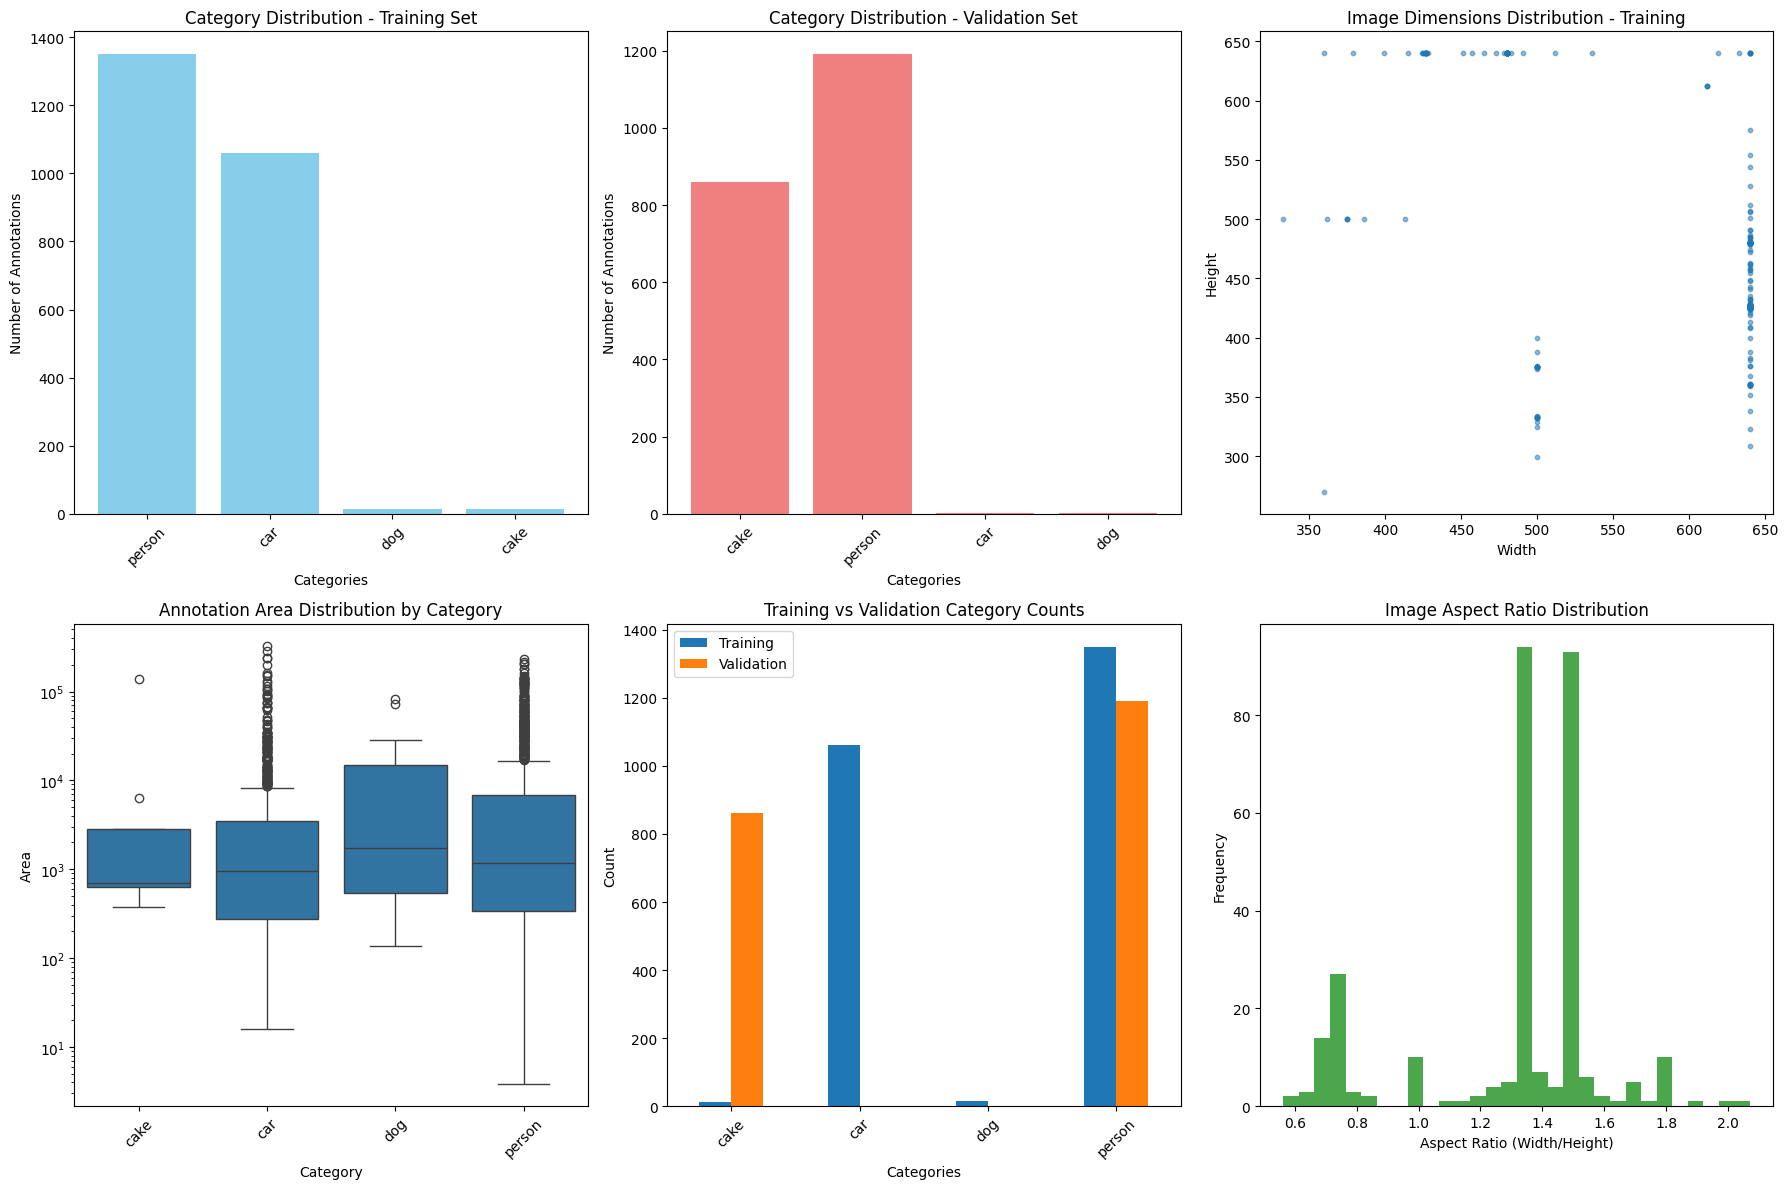

In [ ]:
#  visualizations
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

#  Category distribution - Training
axes[0, 0].bar(train_cat_counts.keys(), train_cat_counts.values(), color='skyblue')
axes[0, 0].set_title('Category Distribution - Training Set')
axes[0, 0].set_xlabel('Categories')
axes[0, 0].set_ylabel('Number of Annotations')
axes[0, 0].tick_params(axis='x', rotation=45)

#  Category distribution - Validation
axes[0, 1].bar(val_cat_counts.keys(), val_cat_counts.values(), color='lightcoral')
axes[0, 1].set_title('Category Distribution - Validation Set')
axes[0, 1].set_xlabel('Categories')
axes[0, 1].set_ylabel('Number of Annotations')
axes[0, 1].tick_params(axis='x', rotation=45)

#  Image dimensions distribution
axes[0, 2].scatter(train_widths, train_heights, alpha=0.5, s=10)
axes[0, 2].set_title('Image Dimensions Distribution - Training')
axes[0, 2].set_xlabel('Width')
axes[0, 2].set_ylabel('Height')

#  Annotation area distribution
all_areas = []
all_categories = []
for cat in target_names:
    if cat in train_areas:
        all_areas.extend(train_areas[cat])
        all_categories.extend([cat] * len(train_areas[cat]))

area_df = pd.DataFrame({'Category': all_categories, 'Area': all_areas})

# Boxplot showing distribution of annotation areas by category (log scale for better visualization)
sns.boxplot(data=area_df, x='Category', y='Area', ax=axes[1, 0])
axes[1, 0].set_title('Annotation Area Distribution by Category')
axes[1, 0].set_yscale('log')
axes[1, 0].tick_params(axis='x', rotation=45)

# Combined category counts comparison between training and validation sets
combined_counts = pd.DataFrame({
    'Training': [train_cat_counts.get(cat, 0) for cat in target_names],
    'Validation': [val_cat_counts.get(cat, 0) for cat in target_names]
}, index=target_names)

# Bar plot comparing category counts in train vs val datasets
combined_counts.plot(kind='bar', ax=axes[1, 1])
axes[1, 1].set_title('Training vs Validation Category Counts')
axes[1, 1].set_xlabel('Categories')
axes[1, 1].set_ylabel('Count')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].legend()

#  Image aspect ratio distribution
aspect_ratios = [w/h for w, h in zip(train_widths, train_heights)]
axes[1, 2].hist(aspect_ratios, bins=30, alpha=0.7, color='green')
axes[1, 2].set_title('Image Aspect Ratio Distribution')
axes[1, 2].set_xlabel('Aspect Ratio (Width/Height)')
axes[1, 2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


# Synthesize sample image examples having bounding boxes semantically labeled using a subset of a COCO dataset.


Visualizing sample training images...


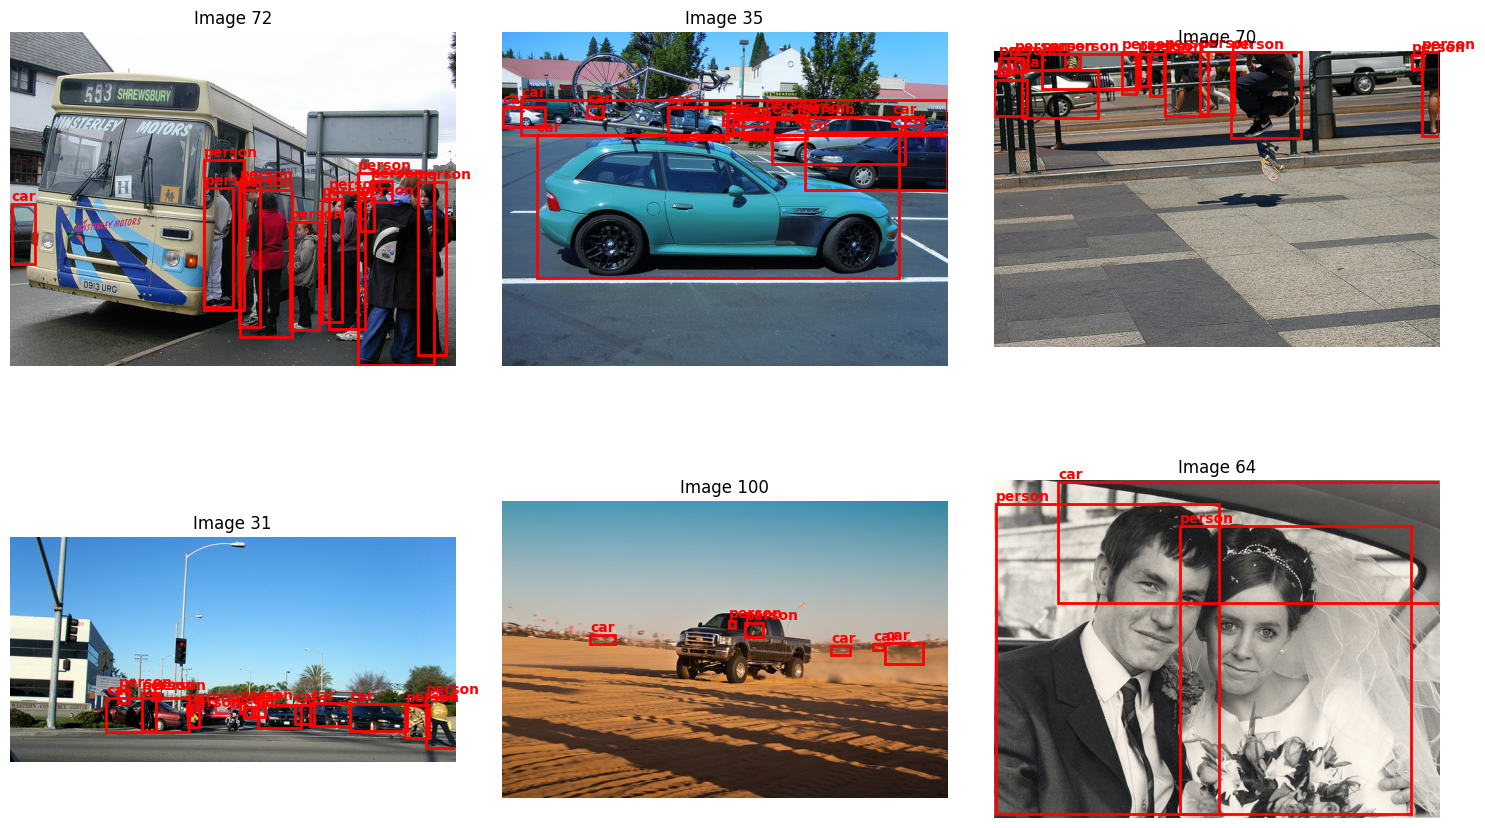

In [ ]:
# Randomly sample image IDs from the first 100 images (or fewer if not enough)

def visualize_samples(coco, img_ids, images_path, num_samples=6):
    """Visualize sample images with annotations"""
    sample_ids = random.sample(img_ids[:100], min(num_samples, len(img_ids)))

    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()

    for i, img_id in enumerate(sample_ids):
        # Load image metadata from COCO
        img_info = coco.loadImgs(img_id)[0]
        img_path = os.path.join(images_path, img_info['file_name'])

       # Skip if image file does not exist
       if not os.path.exists(img_path):
            continue
        # Read and convert image from BGR to RGB for correct color display
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Get annotation IDs for current image and target categories
        ann_ids = coco.getAnnIds(imgIds=img_id, catIds=train_cat_ids)
        anns = coco.loadAnns(ann_ids)

        # Show the image on the subplot
        axes[i].imshow(img)

        # Draw bounding boxes and category names for each annotation
        for ann in anns:
            # Retrieve category name from category dictionary
            cat_name = [k for k, v in train_cat_dict.items() if v == ann['category_id']][0]

            # Extract bounding box coordinates (x, y, width, height)
            bbox = ann['bbox']
            x, y, w, h = bbox
            # Draw a red rectangle for the bounding box
            rect = plt.Rectangle((x, y), w, h, linewidth=2, edgecolor='red', facecolor='none')
            axes[i].add_patch(rect)
            # Put category name text above the bounding box
            axes[i].text(x, y-5, cat_name, color='red', fontsize=10, weight='bold')
            # Set title with image ID and remove axis ticks
            axes[i].set_title(f'Image {img_id}')c
            axes[i].axis('off')

    plt.tight_layout()
    plt.show()

print("Visualizing sample training images...")
visualize_samples(coco_train, train_img_ids, train_images)

#Obtain image IDs and crop resized and combined-masks images in COCO dataset.

In [ ]:
# Gathering training image IDs
def get_image_ids(coco_obj, cat_ids):
    img_ids = []
    for cid in cat_ids:
        img_ids += coco_obj.getImgIds(catIds=cid)
    return list(set(img_ids))

train_ids = get_image_ids(coco_train, target_ids)
val_ids = get_image_ids(coco_val, target_ids)

# extract image + mask
def get_img_mask(coco_obj, image_id, img_dir):
    info = coco_obj.loadImgs(image_id)[0]
    path = os.path.join(img_dir, info['file_name'])
    image = cv2.imread(path)
    image = cv2.resize(image, (256, 256))

    ann_ids = coco_obj.getAnnIds(imgIds=image_id, catIds=target_ids)
    anns = coco_obj.loadAnns(ann_ids)

    mask = np.zeros((info['height'], info['width']), dtype=np.uint8)
    for ann in anns:
        mask = np.maximum(mask, coco_obj.annToMask(ann))
    mask = cv2.resize(mask, (256, 256))
    return image, mask

# Pre-Process and load image and mask data to be used to train and validate.

In [ ]:
# Load data (train and val)
def prepare_dataset(ids, coco_obj, img_dir):
    X, Y = [], []
    for img_id in tqdm(ids):
        img, msk = get_img_mask(coco_obj, img_dir=img_dir, image_id=img_id)
        X.append(img)
        Y.append(msk)
    X = np.array(X) / 255.0
    Y = np.expand_dims(np.array(Y), -1)
    return X, Y

# Prepare training and validation datasets (first 300 images each)
X_train, Y_train = prepare_dataset(train_ids[:300], coco_train, train_images)
X_val, Y_val = prepare_dataset(val_ids[:300], coco_val, val_images)

100%|██████████| 300/300 [02:41<00:00,  1.85it/s]


#Build a light U-Net model of image segmentation with TensorFlow Keras.



In [ ]:
# U-Net
from tensorflow.keras import layers, models

def build_unet(input_shape=(256, 256, 3)):
    inputs = layers.Input(input_shape)

    def conv_block(x, filters):
        x = layers.Conv2D(filters, 3, activation='relu', padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Conv2D(filters, 3, activation='relu', padding='same')(x)
        x = layers.BatchNormalization()(x)
        return x
  # Encoder path
    s1, p1 = encoder_block(inputs, 16)  # First encoder block
    s2, p2 = encoder_block(p1, 32)      # Second encoder block

    # Bottleneck
    b = conv_block(p2, 64)

    # Decoder path
    d1 = decoder_block(b, s2, 32)  # First decoder block with skip connection from s2
    d2 = decoder_block(d1, s1, 16) # Second decoder block with skip connection from s1

    # Output layer with sigmoid activation for binary segmentation mask
    outputs = layers.Conv2D(1, 1, activation='sigmoid')(d2)

    model = models.Model(inputs, outputs)
    return model

#Train and compile U-Net model to do binary image segmentation.

In [ ]:
# Build the U-Net model for segmentation
model = build_unet()

# Compile the model with Adam optimizer and binary cross-entropy loss
# 'accuracy' metric is used to monitor training progress
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print a summary of the model architecture
model.summary()

# Train the model on the training data (X_train, Y_train)
# Validate performance on the validation set (X_val, Y_val)
# Training runs for 5 epochs with batch size of 8
history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=5, batch_size=8)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        448 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │         64 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      2,320 │ batch_normalizat… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │         64 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │      9,248 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (UpSampling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128, 128,  │          0 │ up_sampling2d[0]

 Total params: 119,553 (467.00 KB)

 Trainable params: 118,913 (464.50 KB)

 Non-trainable params: 640 (2.50 KB)

Epoch 1/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 318s 8s/step - accuracy: 0.6002 - loss: 0.7275 - val_accuracy: 0.8606 - val_loss: 0.5963
Epoch 2/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 271s 7s/step - accuracy: 0.7531 - loss: 0.5821 - val_accuracy: 0.8615 - val_loss: 0.4593
Epoch 3/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 309s 8s/step - accuracy: 0.8163 - loss: 0.5069 - val_accuracy: 0.8615 - val_loss: 0.4262
Epoch 4/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 295s 8s/step - accuracy: 0.8529 - loss: 0.4496 - val_accuracy: 0.8615 - val_loss: 0.4102
Epoch 5/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 329s 8s/step - accuracy: 0.8564 - loss: 0.4149 - val_accuracy: 0.8614 - val_loss: 0.3988


#Visualize an input image and original prediction segmentation mask.




1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 788ms/step


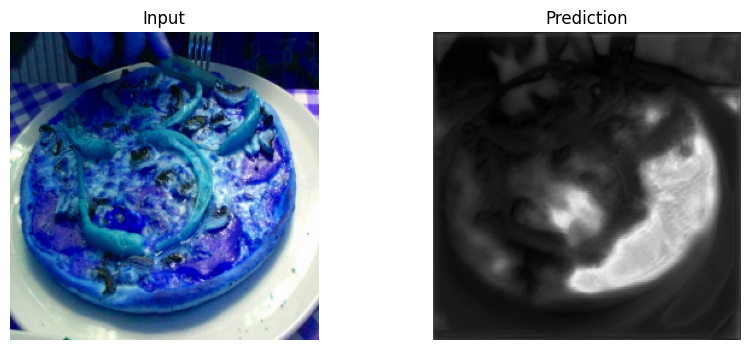

In [ ]:
# Visualise prediction
def show_prediction(img, mask_pred):
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title("Input")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(mask_pred.squeeze(), cmap='gray')
    plt.title("Prediction")
    plt.axis('off')
    plt.show()

# Select a random index from the validation dataset
idx = random.randint(0, len(X_val)-1)

# Predict the mask for the selected validation image
pred = model.predict(np.expand_dims(X_val[idx], axis=0))

# Visualize the input image and its predicted mask
show_prediction(X_val[idx], pred[0])

#Test images: test by predicting and visualising segmentation masks with the trained model.





1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


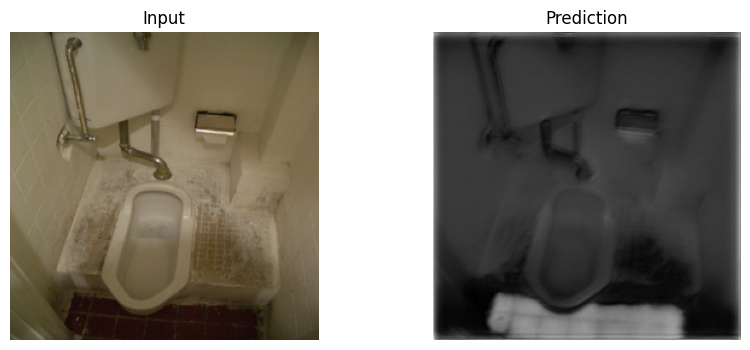

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


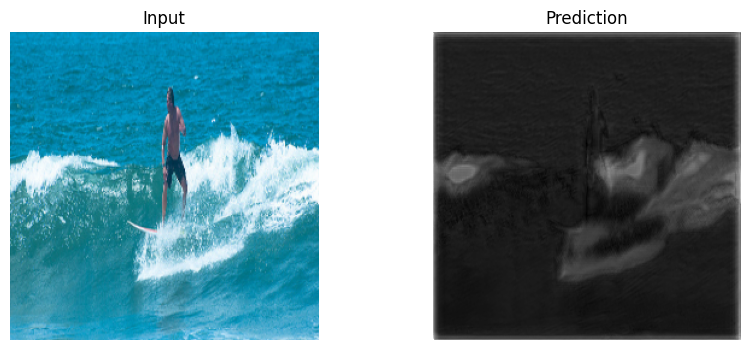

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


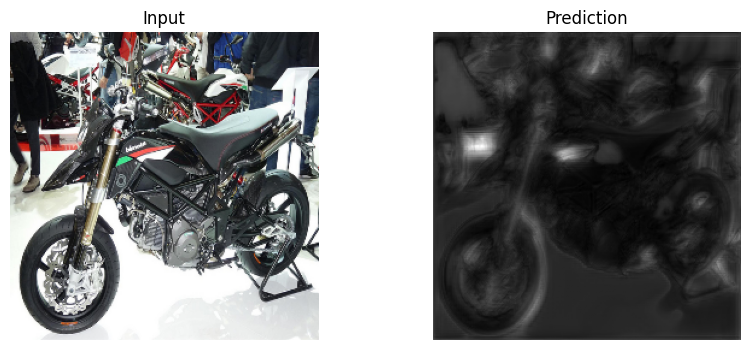

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


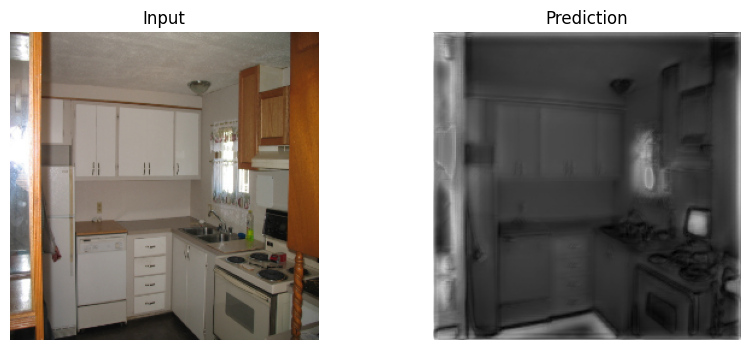

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step


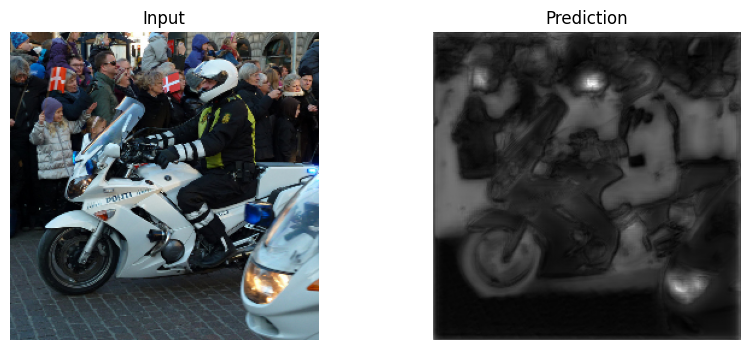

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step


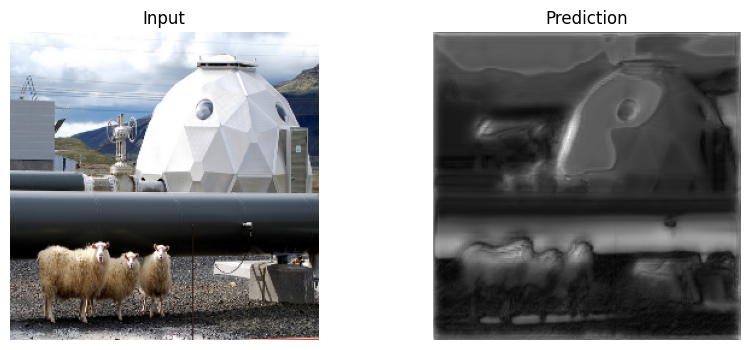

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step


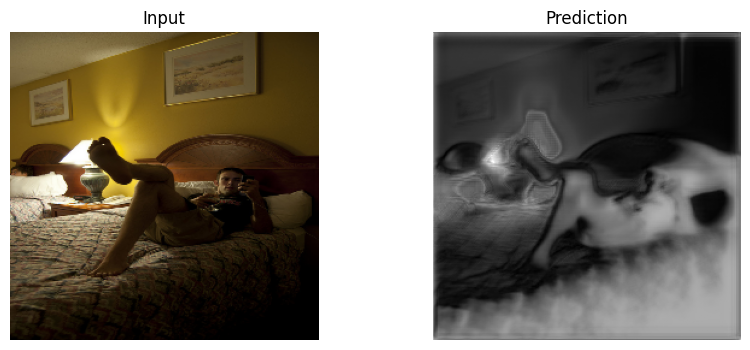

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


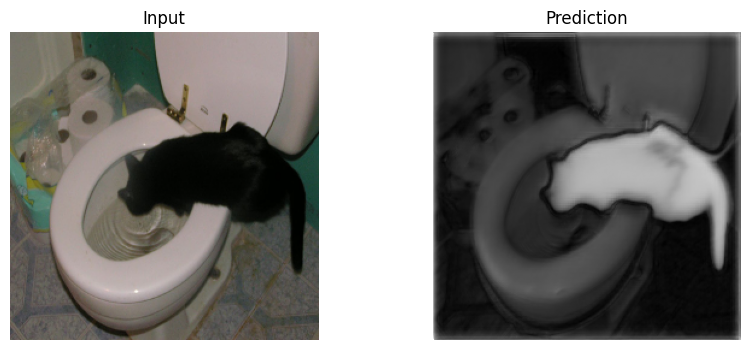

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


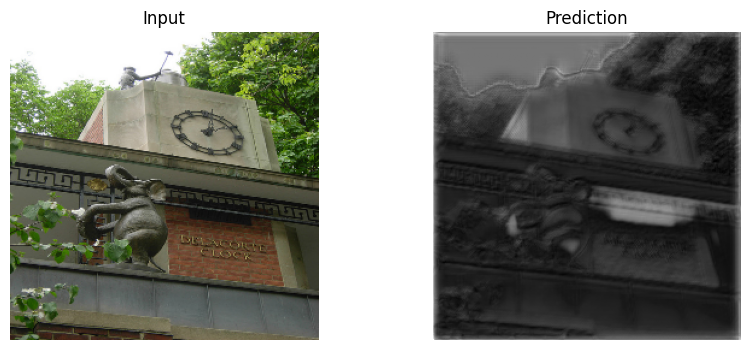

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


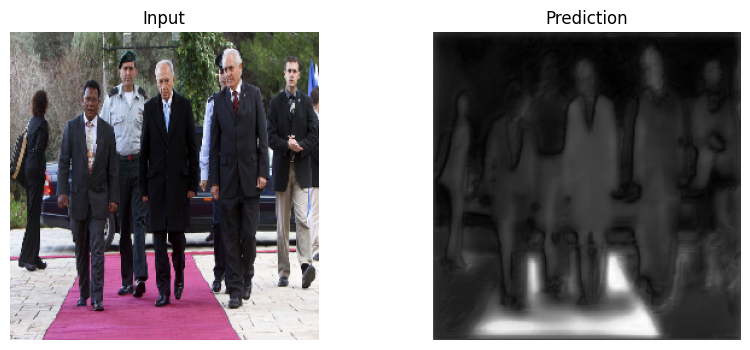

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


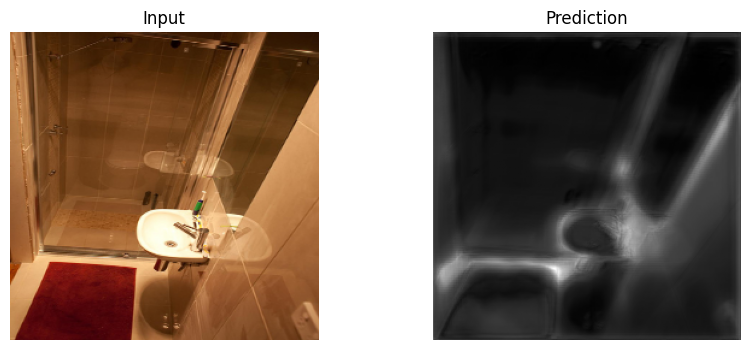

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


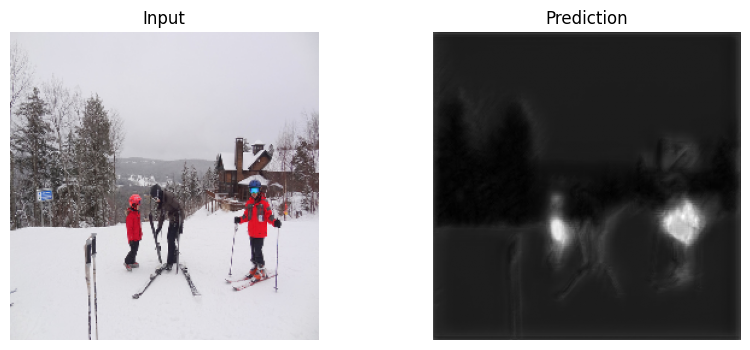

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


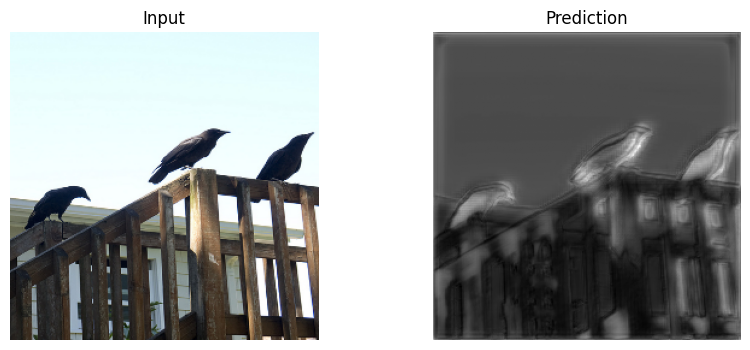

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


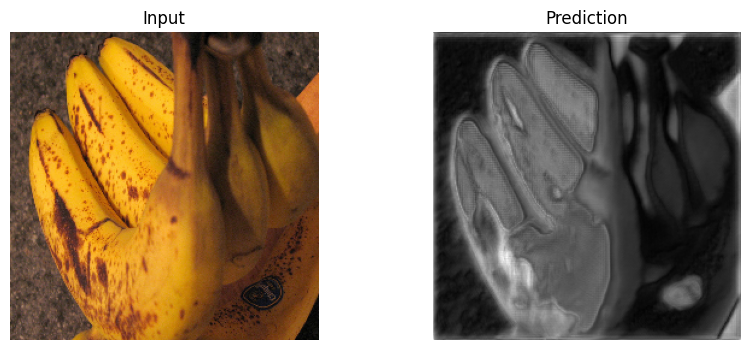

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


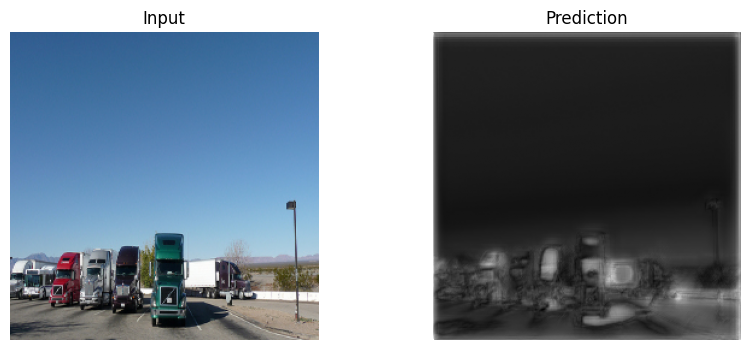

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


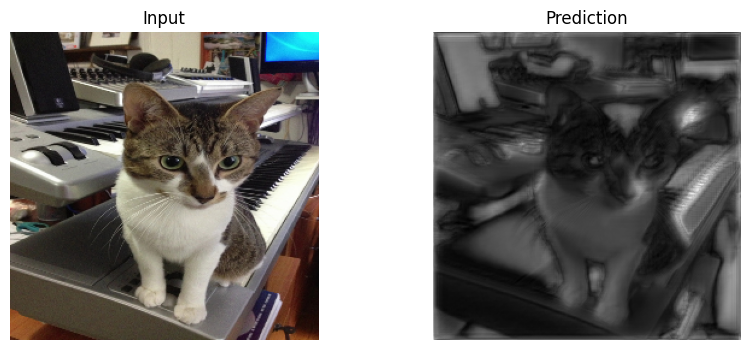

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


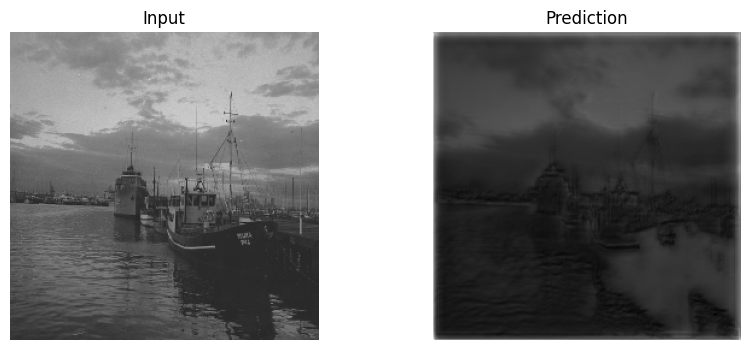

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


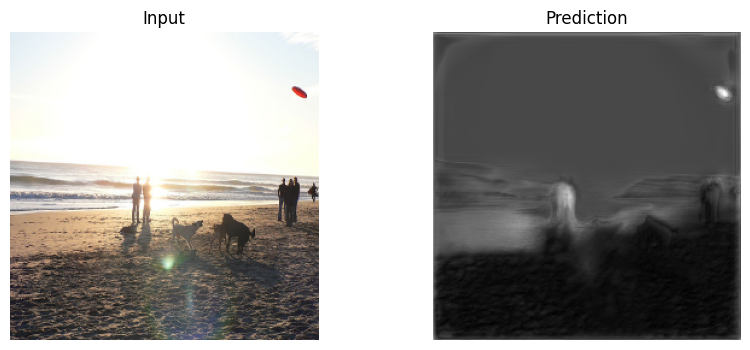

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step


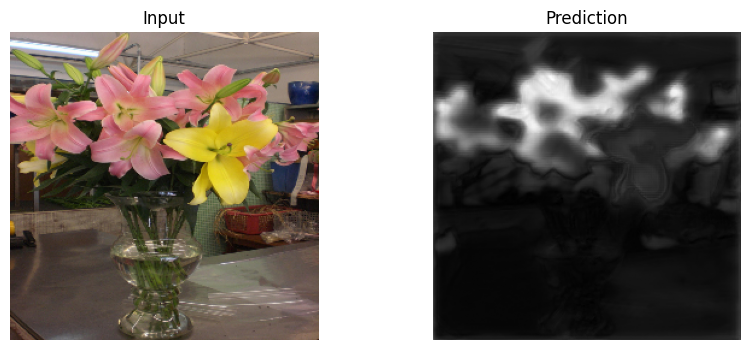

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step


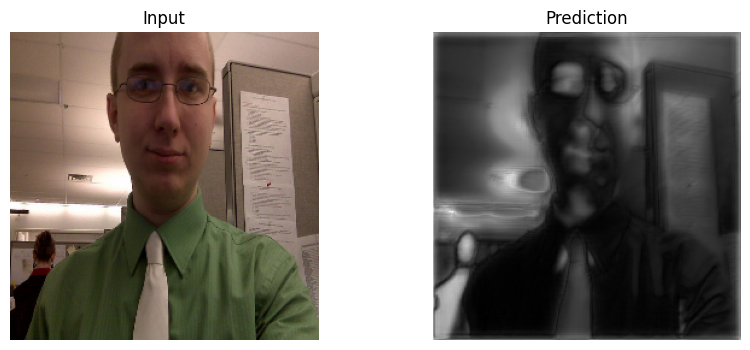

In [ ]:
# List all test image filenames in the test directory
test_imgs = os.listdir(test_path)

# Loop through the first 20 test images
for file in test_imgs[:20]:
    img_path = os.path.join(test_path, file)  # Full path to the image

    img = cv2.imread(img_path)  # Read the image (BGR format)
    img_resized = cv2.resize(img, (256, 256))  # Resize image to model input size

    input_img = img_resized / 255.0  # Normalize pixel values to [0, 1]

    # Predict the segmentation mask for the image
    pred_mask = model.predict(np.expand_dims(input_img, 0))[0]

    # Visualize the resized input image (converted to RGB) and predicted mask side by side
    show_prediction(cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB), pred_mask)